### Apply Contours and Get OCR Results

In [1]:
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2,imutils
from matplotlib import pyplot as plt
import numpy as np
import time as t
# https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import widgets
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
from PIL import Image
from glob import glob
from statistics import mode
import os,pytesseract,editdistance,re

In [2]:
# %%writefile find_contours_on_cropped_img.py
# %load find_contours_on_cropped_img.py
def run_tesseract(img,tmpdir,blur=False,thresh=False,debugLvl=0):
    image = img
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    if debugLvl>0:
        showimg(image)
    
    if debugLvl>1:
        showimg(gray)
        
    # check to see if we should apply thresholding to preprocess the image
    if thresh:
        gray = cv2.threshold(gray, 0, 255,
            cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # make a check to see if median blurring should be done to remove noise
    elif blur:
#         gray = cv2.medianBlur(gray, 3)
        gray = cv2.medianBlur(gray, 1)
    
    # Save image temporarily to apply ocr
    filename = tmpdir+"{}.png".format(os.getpid())
    cv2.imwrite(filename, gray)
    
    text = pytesseract.image_to_string(Image.open(filename))
    
    if debugLvl>1:
        showimg(gray)
        print('----------Tesseract printed text below------ \n'+text)
    return text

def edge_kernel(size , kernel_type, value = -1 ):
    kernel = np.multiply(value , np.ones((size)))
    x = int(size[0]/2)
    y = int(size[1]/2)
    mid_value = -((size[0]*size[1])-1)*value
    if kernel_type == 'edge':
        mid_value = mid_value
    elif kernel_type == 'sharp':
        mid_value = mid_value-2
    kernel[x,y] = mid_value
    return kernel

def isValidContour(cnt,orig_area,big_cnt_area_prcnt_th,smal_cnt_area_prcnt_th):
    x,y,w,h = cv2.boundingRect(cnt)
    if (w*h <= orig_area*big_cnt_area_prcnt_th/100 ) and (w*h >= orig_area*smal_cnt_area_prcnt_th/100):
        return True
    return False

def find_contours_on_cropped_img( fpath,outfilepath,big_cnt_area_prcnt_th=70, smal_cnt_area_prcnt_th=0.2,
                                 debug = 0):
    '''
        Hierarchy in contours is formatted as follows
            [Next, Previous, First_Child, Parent]
            *"Next denotes next contour at the same hierarchical level."*
            *"Previous denotes previous contour at the same hierarchical level."*
            *"First_Child denotes its first child contour."*
            *"Parent denotes index of its parent contour."*
    '''
    img = cv2.imread(fpath)
    orig=img.copy()
    w,h,ch=img.shape
    orig_area=w*h
    c_img = img.copy()
    
    img_median = cv2.medianBlur(img,11) # remove salt and pepper noise
    img_median = cv2.bilateralFilter(img_median,11,75,75) # keep edges sharp
    #     img_median = cv2.GaussianBlur(img,(9,9),-1) # gaussian blur not working here
    
    kernel = edge_kernel((5,5) ,'edge', -1)
    filtered = cv2.filter2D(img_median,-1,kernel)
    
    dil_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (9,9))
    dilated = cv2.dilate(filtered,dil_kernel,iterations = 1)
    
    if debug > 0:
        showimg(filtered)
        showimg(dilated)
        
    img_grey = cv2.cvtColor(dilated, cv2.COLOR_BGR2GRAY)
    th = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13,3)
#     th = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,7,-5)
    #if second paramter is increased than information is lost due to which all rectangles are not identified 
    th_median = cv2.medianBlur(th,1)
    
    im2, contours, hierarchy = cv2.findContours(th_median,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    #tbd clean hierarchy array
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if isValidContour(cnt,orig_area,big_cnt_area_prcnt_th,smal_cnt_area_prcnt_th):
            i = cv2.rectangle(c_img,(x,y),(x+w,y+h),(0,255,0),2)
    
    if debug > 0:
        print('Final image ')
        plt.imshow(c_img,cmap='gray')
        plt.show()
        
        if debug > 1:
            print('img_median')
            plt.imshow(img_median ,cmap='gray')
            plt.show()

            print('filtered')
            plt.imshow(filtered ,cmap='gray')
            plt.show()

            print('dilated')
            plt.imshow(dilated ,cmap='gray')
            plt.show()

            print('img_grey')
            plt.imshow(img_grey,cmap='gray')
            plt.show()

            print('th')
            plt.imshow(th ,cmap='gray')
            plt.show()

            print('th_median')
            plt.imshow(th_median ,cmap='gray')
            plt.show()
    cv2.imwrite(outfilepath ,c_img)
    return orig,orig_area,contours,hierarchy

In [3]:
# %load contour_precedence_txt_keys_utils.py
# Util functions for below
def get_contour_precedence(contour,height, cols):
    '''
        contour ... current contour
        cols ... original image width
    '''
    tolerance_factor = 10
    x,y,w,h = cv2.boundingRect(contour)
    preced1 =  (y*cols/50) + x + h + w
    preced2 =  (y*cols/30) + (float(x)*1.5+float(h/10))
    return preced1
    #return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

def draw_contours(img,contours):
    img=img.copy()
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        i = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    return img

def crop_contour(img,cnt):
    x,y,w,h=cv2.boundingRect(cnt)
    return img[y:y+h,x:x+w]

def process_string(input_str):
    token = input_str.replace('\n', ' ').replace('\r', '')
    token = re.sub( '\s+', ' ',token)
    token = token.strip().lower()
    return token

def get_best_editdistance(a,b):
    a = process_string(a)
    b = process_string(b)
    return editdistance.eval(a,b)

def is_subseq(x, y):
    it = iter(y)
    return all(any(c == ch for c in it) for ch in x)

def getMatchingKeys(txt,key_n_position):
    matchingKeys=[]
    for k in key_n_position:
        # distance=get_best_editdistance(k,txt)
        #if is_subseq(k,txt):# distance < int(len(k)/2) or 
        if k in process_string(txt):
            matchingKeys.append(k)
    return matchingKeys

In [4]:
# %%writefile findcnt.py
def findcnt(mask , img, debugLvl=0):
    h,w,ch=img.shape
    orig_area=w*h
    
    if debugLvl>0:
        plt.imshow(mask)
        plt.show()
    
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)    
    
    contour = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if h>10 and w >20:
            contour.append(cnt)
    
    if debugLvl>0:
        plt.imshow(img)
        plt.show()
    
    # Find Parent Level With Majority of Valid Contours
    valid_contour_parents=[];counter=0
    for cnt in contours:
        if isValidContour(cnt,orig_area,big_cnt_area_prcnt_th=70,smal_cnt_area_prcnt_th=.02):
            valid_contour_parents.append(hierarchy[0][counter][3])
        counter+=1
    target_parent=mode(valid_contour_parents)
    
    # Keep above parent level contours
    counter=0;validContours=[];appHierarchy=[]
    for cnt in contours:
        if isValidContour(cnt,orig_area,big_cnt_area_prcnt_th=70,smal_cnt_area_prcnt_th=.02):
            if hierarchy[0][counter][3]==target_parent:
                validContours.append(cnt)
                appHierarchy.append(hierarchy[0][counter])
        counter+=1
    
    # Sort Contours, Hierarchy top,down,left,right
    validContours.sort(key=lambda x:get_contour_precedence(x, img.shape[0],img.shape[1]))
    
    # Write contour order on image
    for i in range(len(validContours)):
        orig_img = cv2.putText(img, str(i),
                               cv2.boundingRect(validContours[i])[:2], 
                               cv2.FONT_HERSHEY_PLAIN,2,[0,0,250],2)
        (x,y,w,h) = cv2.boundingRect(validContours[i])
        i = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        
    if debugLvl>0:
        plt.imshow(img)
        plt.show()
        
        print('Length of Contours - ',len(validContours))
    return img , validContours

### Process Single Bill

In [ ]:
# Original Directory Containing the Bills is the input
# Predict Using the given model
# Get Contours on the prediction
# Apply Ocr on orig Image (Transalte Contour Predictions back to orig image)

In [5]:
# Model Load Pre-requisites
from __future__ import print_function
import os
from keras.utils import plot_model
from keras import backend as K
from keras import callbacks
import numpy as np
# import pdb
from src.utils.HED_data_parser import DataParser
from src.networks.hed import hed
from src.utils.HED_data_parser2 import DataParser2
from src.utils.HED_test_parser import TestParser
from src.networks.hed2 import hed2

Using TensorFlow backend.


In [6]:
def get_min_max_value(img,h=512,w=512,ch=3):
    max_val=-1;min_val=255
    if ch==3:
        for i  in range(h):
            for j in range(w):
                if img[i][j][0] > max_val:
                    max_val=img[i][j][0]
                if img[i][j][1] > max_val:
                    max_val = img[i][j][1]
                if img[i][j][2] > max_val:
                    max_val = img[i][j][2]
                if img[i][j][0] < min_val:
                    min_val=img[i][j][0]
                if img[i][j][1] < min_val:
                    min_val = img[i][j][1]
                if img[i][j][2] < min_val:
                    min_val = img[i][j][2]
    elif ch==1:
        for i  in range(h):
            for j in range(w):
                if img[i][j][0] > max_val:
                    max_val=img[i][j][0]
                if img[i][j][0] < min_val:
                    min_val=img[i][j][0]
    return min_val,max_val

def generate_minibatches(dataParser, train=True):
    #pdb.set_trace()
    while True:
        if train:
            batch_ids = np.random.choice(dataParser.training_ids, dataParser.batch_size_train)
        else:
            batch_ids = np.random.choice(dataParser.validation_ids, dataParser.batch_size_train*2)
        ims, ems, _ = dataParser.get_batch(batch_ids)
        yield(ims, [ems, ems, ems, ems, ems, ems])
        
def generate_testbatches(dataParser,batch_size=20):
    while True:
        batch_ids = np.random.choice(dataParser.all_ids,batch_size)
        ims, ems, _ = dataParser.get_batch(batch_ids)
        yield(ims, [ems, ems, ems, ems, ems, ems])

In [7]:
model_name = 'BillPredictor'
model_dir     = os.path.join('checkpoints', model_name)
csv_fn        = os.path.join(model_dir, 'train_log.csv')
checkpoint_fn = os.path.join(model_dir, 'checkpoint.{epoch:02d}-{val_loss:.2f}.hdf5')

In [8]:
batch_size_train = 2
# environment
K.set_image_data_format('channels_last')
K.image_data_format()
os.environ["CUDA_VISIBLE_DEVICES"]= '0'
input_shape=(1024,1024,3)

In [9]:
if not os.path.isdir(model_dir): os.makedirs(model_dir)
model = hed2(input_shape=(1024,1024,3),weights=None)
# model.load_weights('./checkpoints/BillSeg_5/checkpoint.279-0.07.hdf5')
model.load_weights('/media/kartik/New Volume/model/freeflow/model/mag/model/model/model/model/model/checkpoint.345-0.06.hdf5')

In [ ]:
# Training call backs
checkpointer = callbacks.ModelCheckpoint(filepath=checkpoint_fn, 
                                         verbose=2, 
                                         save_best_only=True) 
# Make it True if space issue

csv_logger  = callbacks.CSVLogger(csv_fn, append=True, separator=';')

tensorboard = callbacks.TensorBoard(log_dir=model_dir, 
                                    histogram_freq=0, 
                                    batch_size=10,
                                    write_graph=False,
                                    write_grads=True,
                                    write_images=True)
# Set it to false if space issue

In [10]:
# Updated Test Parser
import os
import numpy as np
from PIL import Image

def read_file_list(filelist):
    pfile = open(filelist)
    filenames = pfile.readlines()
    pfile.close()
    print('Number of files ... ',len(filenames))
    filenames = [f.strip() for f in filenames]
    return filenames

class TestParser():
    def __init__(self,
        img_mask_pair_file='/home/ydalal/rasidrev/resources/HED-BSDS/train_pair.lst',input_shape=(480,480,3)):
        print('input dir ...',img_mask_pair_file)
        self.train_file = img_mask_pair_file
        self.training_pairs = read_file_list(self.train_file)
        self.samples = [c.strip() for c in self.training_pairs]
        self.n_samples = len(self.training_pairs)
        self.all_ids = list(range(self.n_samples))
        np.random.shuffle(self.all_ids)
        h,w,_=input_shape
        self.image_width = h
        self.image_height = w
        self.target_regression = True
        
    def get_test_batch(self):
        return self.get_batch(all_ids)

    def get_batch(self, batch):
        filenames = []
        images = []
        edgemaps = []
        for idx, b in enumerate(batch):
            im = Image.open(self.samples[b])
#             im = im.resize((self.image_width, self.image_height))
            im.thumbnail((self.image_width,self.image_height), Image.ANTIALIAS)
            img = np.array(im)
            if len(img.shape) == 2:
#                 img = np.resize(img, (self.image_height, self.image_width, 3))
                img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            delta_w = self.image_width - img.shape[1]
            delta_h = self.image_height - img.shape[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)
            color = [0, 0, 0]
            im = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
            print(self.samples[b],im.shape)
            im = np.array(im, dtype=np.float32)
            im = im[..., ::-1] # RGB 2 BGR
            im[..., 0] -= 103.939
            im[..., 1] -= 116.779
            im[..., 2] -= 123.68
            images.append(im)
            filenames.append(self.samples[b])
        images   = np.asarray(images)
        return images, edgemaps, filenames

class TestParserSingleFile():
    def __init__(self,imgFilePath,input_shape=(480,480,3)):
        self.samples = [imgFilePath]
        self.n_samples = 1
        self.all_ids = [0]
        h,w,_=input_shape
        self.image_width = h
        self.image_height = w
        self.target_regression = True
        
    def get_test_batch(self):
        return self.get_batch(all_ids)

    def get_batch(self, batch):
        filenames = []
        images = []
        edgemaps = []
        for idx, b in enumerate(batch):
            im = Image.open(self.samples[b])
#             im = im.resize((self.image_width, self.image_height))
            im.thumbnail((self.image_width,self.image_height), Image.ANTIALIAS)
            img = np.array(im)
            if len(img.shape) == 2:
#                 img = np.resize(img, (self.image_height, self.image_width, 3))
                img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            print('SHAPE BEFORE PADDING, w,h = ',img.shape[1],img.shape[0])
            delta_w = self.image_width - img.shape[1]
            delta_h = self.image_height - img.shape[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)
            color = [0, 0, 0]
            im = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
            print(self.samples[b],im.shape)
            im = np.array(im, dtype=np.float32)
            im = im[..., ::-1] # RGB 2 BGR
            im[..., 0] -= 103.939
            im[..., 1] -= 116.779
            im[..., 2] -= 123.68
            images.append(im)
            filenames.append(self.samples[b])
        images   = np.asarray(images)
        return images, edgemaps, filenames

### Run Everything From Here

In [11]:
# sudo pip3 install fpdf

In [12]:
output_dir = './results/ocr_results/'
input_dir = '/home/ydalal/rasidrev/resources/bhavuk/oct_mar/anjali/Invoices/'

In [13]:
tmpimg = cv2.imread('/home/kartik/rasidrev/resources/anil chem img/scanned_22_dec/wb/IMG_20180104_141510.jpg')
tmpimg.shape

(4160, 3120, 3)

SHAPE BEFORE PADDING, w,h =  724 1024
/home/kartik/rasidrev/resources/raw_images/28decscanned/23.jpg (1024, 1024, 3)
1/1 [==============================] - 0s 97ms/step
True


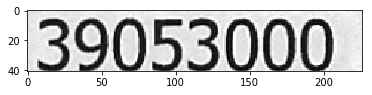


True


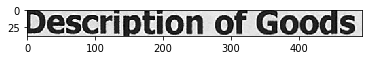


True


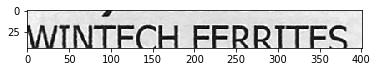

NTMNTECL EEDDTTEC
True


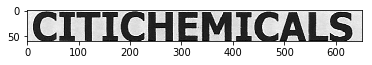


True


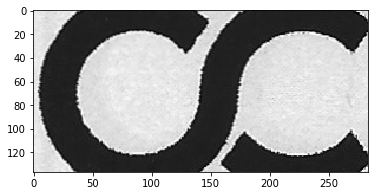

True

In [38]:
name = '23.jpg'
imgFilePath='/home/kartik/rasidrev/resources/raw_images/28decscanned/'+name

testParser=TestParserSingleFile(imgFilePath=imgFilePath,input_shape=input_shape)
test_generator=generate_testbatches(testParser,batch_size=1)
ims,_=next(test_generator)
predictions=model.predict(ims,batch_size=1,verbose=1,steps=None)


mask = predictions[5][0].squeeze()*255

## READ ORIGINAL IMAGE, PRINT IT'S SHAPE
orig_img = cv2.imread(imgFilePath)
o_h,o_w,o_ch= orig_img.shape
# print('Image Shape ', o_h,o_w,o_ch)
cv2.imwrite('mask.jpg' , mask)
mask = cv2.imread('mask.jpg' , 0)

## USE THUMBNAIL TO REDUCE IMAGE WITH ASPECT RATIO PRESERVED, PRINT IT'S SHAPE
image_width=1024;image_height=1024
im = Image.open(imgFilePath)
im.thumbnail((image_height,image_width),Image.ANTIALIAS)
im = np.array(im)
rs_h = im.shape[0]
rs_w = im.shape[1]
# print('Image Shape After Thumbnail , ',im.shape[0],im.shape[1])

## ADD PADDING TO THE ABOVE  IMAGE IF REQUIED
delta_w = image_width - im.shape[1]
delta_h = image_height - im.shape[0]
left, right = delta_w//2, delta_w//2
top, bottom = delta_h//2, delta_h//2
color = [0, 0, 0]
# top, bottom, left, right (number of pixels to be padded in each direction)
img = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
# print('top bottom left right = ',top, bottom, left, right)
# print('Image Shape After Adding Padding , ',img.shape[0],img.shape[1])
c_img ,contours = process(img , mask)
show(c_img)
# cv2.imwrite('finalimg.png',img)
counter = 0 
for cnt in contours:
    try:
        x,y,w,h = cv2.boundingRect(cnt)
        #print(x,y,w,h)
#         plt.imshow(img[y:y+h,x:x+w])
#         plt.show()
        # Remove Padding Effect
        x-=left
        y-=top
        # Upscale to orig Image
        ratio = float(o_h)/rs_h
        x = int(float(x) * ratio)
        y = int(float(y) * ratio)
        w = int(float(w)*ratio) # new width
        h = int(float(h)*ratio) # new height
#         print(x,y,w,h)
        if counter>0:
            #print(counter)
            i = orig_img[y:y+h,x:x+w].copy()
            #cropped_img = orig_img[y:y+h,x:x+w]
            cropped_img = orig_img[y-9:y+h+9,x-5:x+w+9]
            #re = cropped_img.resize(())
            #word_img = process_cnt(cropped_img)
            tmp_img_path = './temp/tmp_img.jpg'
            print(cv2.imwrite(tmp_img_path,cropped_img))
#         pdf.image(tmp_img_path,0,0,w,h)
            txt = run_tesseract(,blur=False,tmpdir='./temp/')
#         for line in txt:
#             pdf.cell(40, 10, unicode(line, "utf-8"))
            show(cropped_img , 1)
            print(txt)
            #show(word_img)
            #show(word_img)
            #plt.imshow(cropped_img)
            #plt.show()
            #plt.hist(cropped_img.ravel(),256,[0,256]); plt.show()
        counter+= 1 
        
    except:
        pass
cv2.imwrite('orig_img.png',orig_img)
# pdf.output('tuto1.pdf', 'F')

In [18]:
def process_cnt(img , sigma = 0.33, ):
    th2 = auto_canny(img , sigma)
    #show(th2)
    #ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS , (5,5))
    th2 = cv2.morphologyEx(th2, cv2.MORPH_CLOSE, kernel)
    #show(th2)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS , (3,3))
    th2 = cv2.morphologyEx(th2, cv2.MORPH_OPEN, kernel)
    #show(th2)
    word_img , _= findcnt_on_cropped_img(th2 , img)
    return word_img

In [37]:
#mask must be gray scale
#C_img is for colored image
def process(c_img , mask):    
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS , (1,9))
    kernel = np.ones((9,1))
    ret,th1 = cv2.threshold(mask,250,255,cv2.THRESH_BINARY)
    opening = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel)
    erosion = cv2.erode(opening , kernel , 1)
    img ,c = findcnt_on_full_img(erosion, c_img)
    
    return c_img , c 

In [35]:
def show(img , i = 0):
    if i == 1 :
        plt.imshow(img)
        plt.show()
    elif i == 2:
        plt.imshow(img , cmap='gray')
        plt.show()
    else:
        cv2.imshow('image' , img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
def findcnt_on_full_img(mask , img):
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    contour = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if h>5 and w >5:
            #i = cv2.rectangle(img,(x+1,y+1),(x+w-1,y+h-1),(0,255,0),1)
            i = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
            contour.append(cnt)
        
    return img , contour

def findcnt_on_cropped_img(mask , img):
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    contour = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if h>2 and w >2:
            #i = cv2.rectangle(img,(x+1,y+1),(x+w-1,y+h-1),(0,255,0),1)
            i = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
            contour.append(cnt)
        
    return img , contour

def save(c_img , c , imgpath , xmlPath ):
    imgname = imgpath.split('/')[-1]
    xml_name = imgname.split('.')[0]
    x = gen_xml(contours=c , file_path=imgpath , folder='invoices' , img_name=imgname , img_size=c_img.shape)
    tree = et.ElementTree(x)
    tree.write(xmlPath+xml_name+'.xml')
    
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

def edge_kernel(size , kernel_type, value = -1 ):
    kernel = np.multiply(value , np.ones((size)))
    x = int(size[0]/2)
    y = int(size[1]/2)
    mid_value = -((size[0]*size[1])-1)*value
    if kernel_type == 'edge':
        mid_value = mid_value
    elif kernel_type == 'sharp':
        mid_value = mid_value+1
    kernel[x,y] = mid_value
    return kernel

# %load gen_xml.py

def prettify(elem):
    """Return a pretty-printed XML string for the Element.
    """
    rough_string = et.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

def cmn_xml(folder_name , img_name , path, img_size):

    top = et.Element('annotation')

    comment = et.Comment('contours')
    top.append(comment)

    folder = SubElement(top, 'folder')
    folder.text = folder_name

    filename = SubElement(top, 'filename')
    filename.text = img_name
    
    path_tag = SubElement(top, 'path')
    path_tag.text = path
    
    src = SubElement(top , 'source')
    db = SubElement(src , 'database')
    db.text = 'Unknown'
    
    size = SubElement(top , 'size')
    width = SubElement(size , 'width')
    width.text = str(img_size[1])
    height = SubElement(size , 'height')
    height.text = str(img_size[0])
    depth = SubElement( size ,'depth')
    depth.text = str(img_size[2])
    return top

def xml_object(top , i , contour):
    
    obj = SubElement(top , 'object')
    name_tag = SubElement(obj , 'name')
    name_tag.text = str(i)
    pose_tag = SubElement(obj , 'pose')
    pose_tag.text = 'Unspecified'
    truncated_tag = SubElement(obj , 'truncated')
    truncated_tag.text = str(0)
    difficult_tag = SubElement(obj , 'difficult')
    difficult_tag.text = str(0)
    box = SubElement(obj , 'bndbox')
    xmin = SubElement(box , 'xmin')
    xmin.text = str(contour[0])
    ymin = SubElement(box , 'ymin')
    ymin.text = str(contour[1])
    xmax = SubElement(box , 'xmax')
    xmax.text = str(contour[2])
    ymax = SubElement(box , 'ymax')
    ymax.text = str(contour[3])
    
    return top

def gen_xml(contours ,folder, img_name , file_path , img_size):
    top = cmn_xml(folder , img_name , file_path ,img_size)
    i = 0
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        a = (x,y,x+w,y+h)
        
        obj = xml_object(top , i , a)
        top = obj
        i = i+1
        
    return top 

### Write Excel Now

In [ ]:
def get_header_for_contour(contours,b_x,b_y,b_w,b_h,tolerance=5):
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        # must be above, must have width +=-tolerance as below
        if y<b_y and (x >= b_x - tolerance and x <= b_x + tolerance)and (w >= b_w - tolerance and w <= b_w + tolerance) and h<(b_h/2.0):
            return (x,y,w,h)
    return None

In [ ]:
# Write Excel with columns with headers from bill
import xlsxwriter
workbook = xlsxwriter.Workbook('demo1.xlsx')
worksheet = workbook.add_worksheet()
# worksheet.set_column('A:A', 20)
bold = workbook.add_format({'bold': True})
row=4;col=0
for cnt in contours:
    try:
        x,y,w,h = cv2.boundingRect(cnt)
        header = get_header_for_contour(contours,x,y,w,h,tolerance=10)
        if header!=None:
            print('Contour With Header !!')
            x0,y0,w0,h0=header
            # Prepend Header To Current Contour
            x=min(x,x0); y=min(y,y0);w=max(w,w0);h+=h0
        else:
            print('None Header Contour !!')
            continue
        # Remove Padding Effect
        x-=left
        y-=top
        # Upscale to orig Image
        ratio = float(o_h)/rs_h
        x = int(float(x) * ratio)
        y = int(float(y) * ratio)
        w = int(float(w)*ratio) # new width
        h = int(float(h)*ratio) # new height
        
        plt.imshow(orig_img[y:y+h,x:x+w])
        plt.show()
        
        txt = run_tesseract(orig_img[y:y+h,x:x+w],blur=False,tmpdir='./tmp/')
        print(txt)
        max_col_width = 0;curr_row=row; first_line=True
        for line in txt.split('\n'):
            if first_line:
                worksheet.write(curr_row,col,line.strip(),bold)
                first_line=False
            else:
                worksheet.write(curr_row,col,line.strip())
            curr_row+=1;
            if max_col_width<len(line):
                max_col_width=len(line)
        worksheet.set_column(col,col,max_col_width)
        col+=1;
        
    except:
        pass
workbook.close()

In [ ]:
img = cv2.imread(impath)
orig_img=img.copy()

tmpdir='./tmp/'
index=0
for cnt in contours:
    cv2.imwrite(tmpdir+str(index)+'.jpg',crop_contour(orig_img,cnt))
    txt = run_tesseract(crop_contour(orig_img,cnt),tmpdir=tmpdir)
    print(txt)
    index+=1
    #matching_keys = getMatchingKeys(txt,key_n_position)
cv2.imwrite(tmpdir+'main.jpg',img)

### Identify Contours on All Bills

In [ ]:
# Apply OCR on already predicted images
impath='./results/279_predictions/img/1img.png'
maskpath='./results/279_predictions/pred/1prediction.png'

mask = cv2.imread(maskpath,0)
x = np.where(mask < 70)
mask[x] = 0

img = cv2.imread(impath)
orig_img=img.copy()
cnt_img, contours = findcnt(mask,img,debugLvl=0)
tmpdir='./tmp/'
index=0
for cnt in contours:
    cv2.imwrite(tmpdir+str(index)+'.jpg',crop_contour(orig_img,cnt))
    txt = run_tesseract(crop_contour(orig_img,cnt),tmpdir=tmpdir)
    print(txt)
    index+=1
    #matching_keys = getMatchingKeys(txt,key_n_position)
cv2.imwrite(tmpdir+'main.jpg',img)

In [ ]:
billid=100

input_dir='./results/279_predictions/'
out_dir='./results/279_predictions/cnt/'

for billid in range(0,279):
    impath=input_dir+'/img/%simg.png'%(billid)
    maskpath=input_dir+'/pred/%sprediction.png'%(billid)
    assert(os.path.exists(impath))
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    outpath=out_dir+'%sprediction.png'%(billid)
    
    print('processing ... ',billid)
    mask = cv2.imread(maskpath,0)
    x = np.where(mask < 70)
    mask[x] = 0
    
    img = cv2.imread(impath)
    cnt_img, contours = findcnt(mask,img)
    cv2.imwrite(outpath,cnt_img)